In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import KFold

1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [55]:
df =pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


2) Convert `default` and `student` to categorical variables.

In [56]:
df_default = pd.get_dummies(df['default'])
df_default.rename(columns={'Yes' : 'default'}, inplace=True)
df_student = pd.get_dummies(df['student'])
df_student.rename(columns={'Yes' : 'student'}, inplace=True)
df_final = pd.concat([df[['balance', 'income']],df_default, df_student],axis=1)
df_final = df_final.drop(['No'], axis=1)
df_final.head()

,balance,income,default,student
0,729.526495,44361.625074,0,0
1,817.180407,12106.134700,0,1
2,1073.549164,31767.138947,0,0
3,529.250605,35704.493935,0,0
4,785.655883,38463.495879,0,0


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

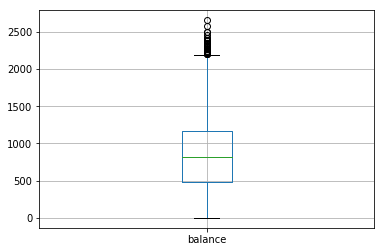

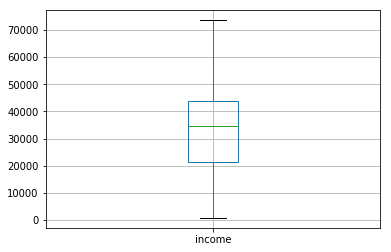

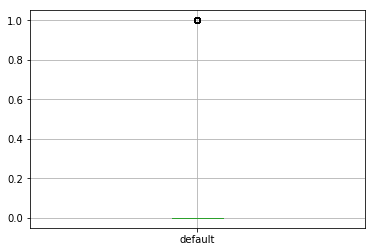

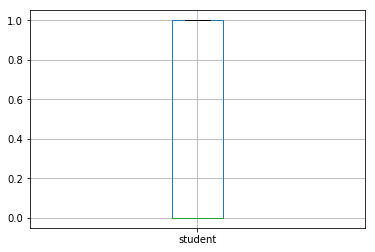

In [57]:
df_final.boxplot('balance')
plt.show()
df_final.boxplot('income')
plt.show()
df_final.boxplot('default')
plt.show()
df_final.boxplot('student')
plt.show()

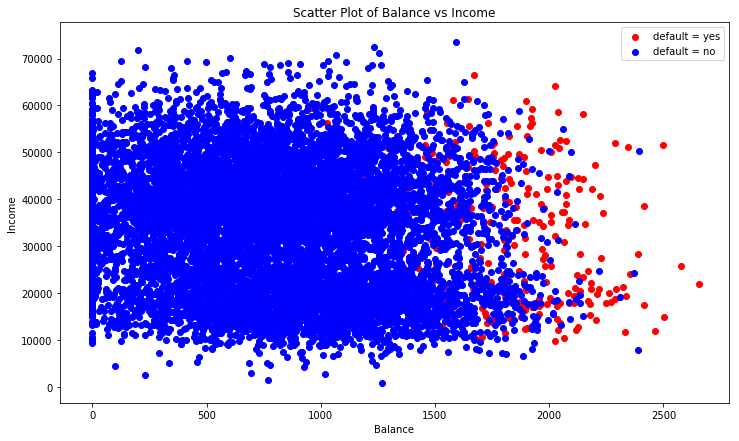

In [58]:
default_yes = df_final[df_final['default'] == 1]
default_no = df_final[df_final['default'] == 0]
fig = plt.figure(figsize=(12,7))
plt.scatter(default_yes['balance'], default_yes['income'], color='red', label='default = yes')
plt.scatter(default_no['balance'], default_no['income'], color='blue', label='default = no')
plt.title('Scatter Plot of Balance vs Income')
plt.xlabel('Balance')
plt.ylabel('Income')
plt.legend()
plt.show()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

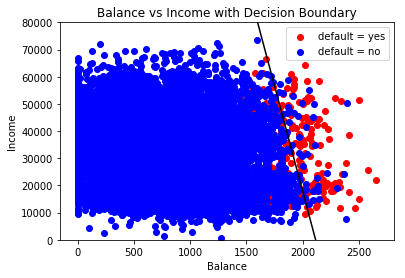

Area under the ROC curve : 0.907882


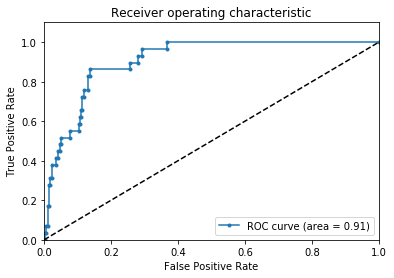

In [59]:
student_data = df_final[df_final['student'] == 1]
x = student_data[['balance', 'income']]
y = student_data['default']

# data splitting and logistical regression
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2, random_state=10)
regr = LogisticRegression(penalty='l1')
clf = regr.fit(x_train, y_train)
predict = regr.predict(x_test)
probas_ = regr.fit(x_train,y_train).predict_proba(x_test)

# decision boundary 
coef = clf.coef_[0]
b = clf.intercept_
x = np.arange(0,2600,1)
y = (b + coef[0]*x)/(-coef[1])

# plot data with decision boundary 
# fig = plt.figure(figsize=(12,7))
plt.plot(x,y, color='black')
plt.scatter(default_yes['balance'], default_yes['income'], color='red', label='default = yes')
plt.scatter(default_no['balance'], default_no['income'], color='blue', label='default = no')
plt.ylim(0,80000)
plt.title('Balance vs Income with Decision Boundary')
plt.xlabel('Balance')
plt.ylabel('Income')
plt.legend()
plt.show()

# compute auc roc 
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

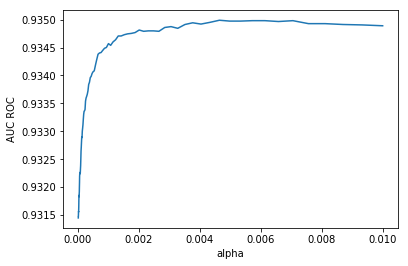

Optimal alpha: 0.00464158883361


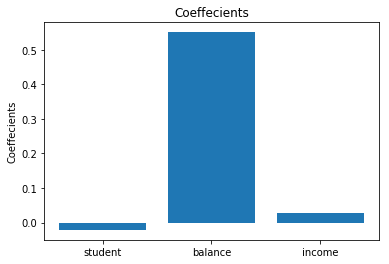

Coefficients:  [[-0.02130149  0.55060587  0.02765126]]


In [60]:
x = df_final[['student', 'balance', 'income']]
y = df_final['default']

# data splitting and Ridge regression
scaler = StandardScaler()
x = scaler.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2, random_state=10)

alphas = np.logspace(-5,-2,100)
score = []
for alpha in alphas:
    regr = LogisticRegression(C=alpha, penalty='l2')
    probas_ = regr.fit(x_train, y_train).predict_proba(x_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    score.append(roc_auc)
alpha_optim = alphas[np.argmax(score)]

plt.plot(alphas,score)
plt.xlabel('alpha')
plt.ylabel('AUC ROC')
plt.show()
print("Optimal alpha:", alpha_optim)

regr = LogisticRegression(C=alpha_optim, penalty='l2')
regr.fit(x_train, y_train)

# plot coeff
fig, ax = plt.subplots()
ax.bar(np.linspace(0,2,3),regr.coef_[0])
ax.set_ylabel('Coeffecients')
ax.set_title('Coeffecients')
ax.set_xticks(np.arange(3))
ax.set_xticklabels(('student', 'balance', 'income'))

plt.show()

print("Coefficients: ", regr.coef_)

**A: ** The performance does not improve with the addition of the student variable. As can be seen with the coefficients, the balance is the variable that is the most important feature.

Area under the ROC curve : 0.934988


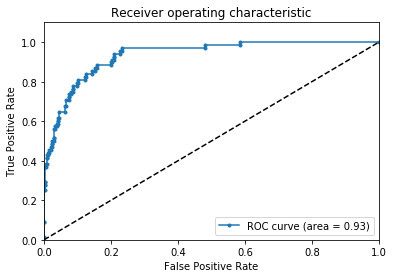

In [61]:
# compute auc roc 
regr = LogisticRegression(C=alpha_optim, penalty='l2')
regr.fit(x_train, y_train)
probas_ = regr.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

[ 0.95312476  0.95819506  0.9377659   0.9627522   0.93503582]


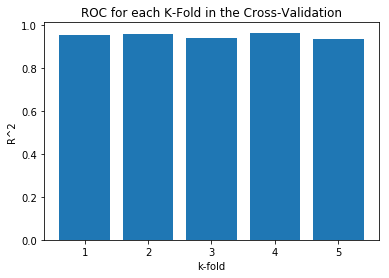

In [62]:
from sklearn.model_selection import cross_val_score

# cross validation
regr = LogisticRegression(C=alpha_optim, penalty='l2')
regr.fit(x_train, y_train)
scores = cross_val_score(regr, x, y, cv=5, scoring='roc_auc')
print(scores)
plt.bar(range(1,6),scores)
plt.title('ROC for each K-Fold in the Cross-Validation')
plt.xlabel('k-fold')
plt.ylabel('R^2')
plt.show()

**A: ** The 5 fold cross validation checks that the model is robust. You can see that all the scores are very high for each fold.

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

In [63]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

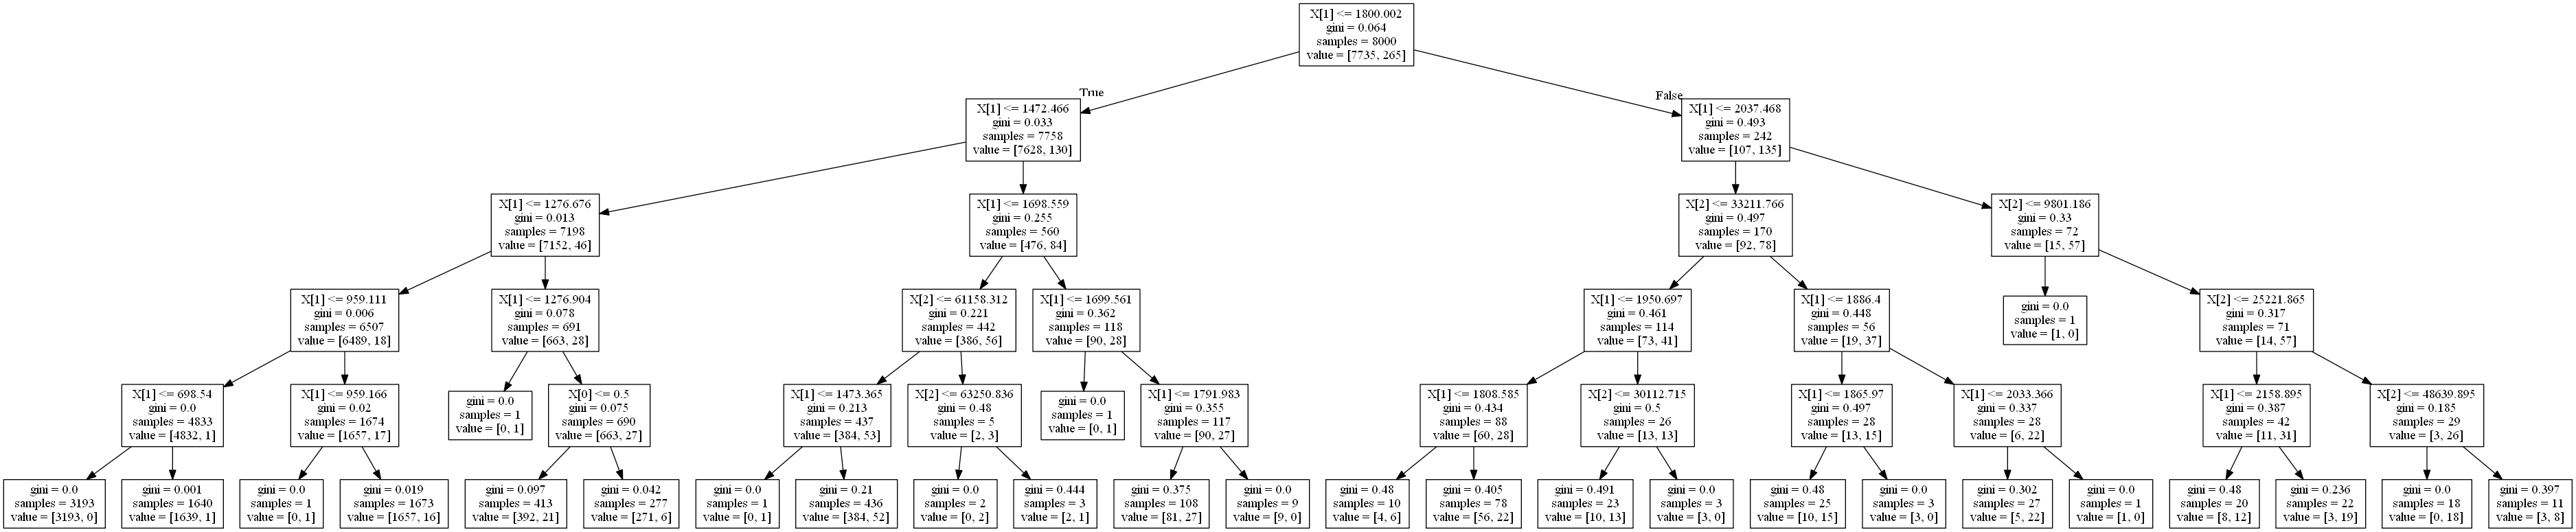

In [64]:
from IPython.display import Image
from sklearn.tree import DecisionTreeRegressor
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

x = df_final[['student', 'balance', 'income']]
y = df_final['default']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2, random_state=10)

clf = DecisionTreeClassifier(max_depth=5)
clf.fit(x_train, y_train)
y2 = clf.predict(x_test)
probas_ = clf.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)

# decision tree 
visualize_tree(clf, feature_names=x_train.columns)
dot_data=export_graphviz(clf, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

Area under the ROC curve : 0.903750


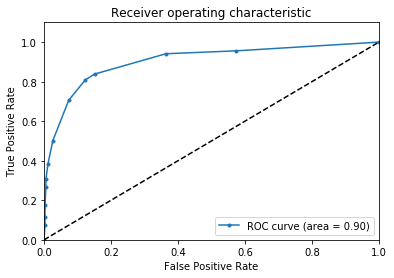

In [65]:
# AUC ROC 
print("Area under the ROC curve : %f" % roc_auc)
generate_ROCplot(fpr,tpr,'LR',roc_auc)

**A**: Looking at the AUC ROC values, it seems like the decision tree at depth 5 performed slightly worse. 

8) Find the optimal decision tree depth and compute the AUC ROC. 

Optimal tree depth: 4


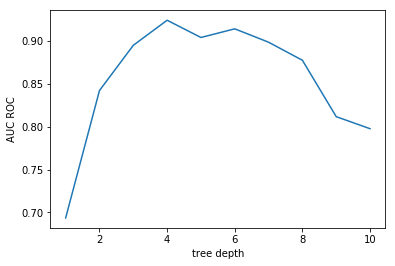

Area under the ROC curve : 0.923833


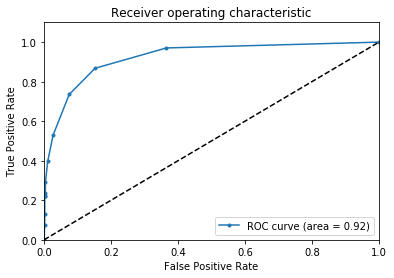

In [66]:
from sklearn.tree import DecisionTreeClassifier

scores=[]
depths = np.arange(1,11)
for depth in depths:
    clf = DecisionTreeClassifier(max_depth=depth)
    clf.fit(x_train, y_train)
    probas_ = clf.predict_proba(x_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    scores.append(roc_auc)
n_optim = depths[np.argmax(scores)]
print("Optimal tree depth:", n_optim)

# plot the score vs the depth
plt.plot(depths,scores)
plt.xlabel('tree depth')
plt.ylabel('AUC ROC')
plt.show()

# Plots ROC
clf = DecisionTreeClassifier(max_depth=n_optim)
clf.fit(x_train, y_train)
probas_ = clf.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

generate_ROCplot(fpr,tpr,'LR',roc_auc)